# Policy Gradient Methods
## Track 3: Policy Gradient with Traces
### Rithesh Kumar (260848114)

### Overview:
* In this work, we implement **Actor Critic with Eligibility Traces**, for the **episodic** setting.
* More specifically, we choose the episodic environment as **CartPole-v1**, which runs for a maximum timesteps of 500. The maximum possible reward of this environment is 500, ie, **Maximum Average reward = 500**
* We specifically implemented the Actor Critic with Eligibility Traces algorithm from Sutton & Barto, in Page 274.

### Model:
* To make things easy, we only used **Linear Function Approximation**. Therefore, the Actor has a parameter matrix $\theta \in \mathbb{R}^{d\ x\ |A|}$, and the Critic has a parameter vector $w \in \mathbb{R}^d$, where $d$ is the dimension of the observation vector, and $|A|$ is the no. of possible actions.

### Observations and Learning points:
* **Hyperparameter Search** is the single most important thing in RL!!!
* It was also very VERY important to note that **setting the same seed** between hyperparameter search experiments was super crucial. This is often overlooked.
* With a grid search over the learning rates $\alpha_\text{actor}$ and  $\alpha_\text{critic}$, we were able to **solve** CartPole-v1 for all the 3 models (Traces on both actor-critic, Trace only on Actor, Trace only on Critic)
* The **most interesting result** for us personally, was seeing that Actor Critic with Trace only on Critic (with $\lambda_\text{critic} = 0.8$), learns to **solve** the CartPole-v1 environment in **as few as 20 episodes!!** (*Is this a new record?* :p)
* While reporting on the effect of gamma (discounting factor), we notice that some gamma values perform more optimally in some cases than others, although the difference in performance wasn't bigger than 40 average reward. We performed these experiments by choosing a value of gamma, and optimizing the step sizes ($\alpha_\text{actor}$ and $\alpha_\text{critic}$) internally for value of $\gamma$, and then comparing average reward per episode between the different values of gamma.
* We similarly report on the effect of lambda (trace parameter), by taking a limited environment, where we fix $\lambda_\text{actor} = 0$ and $\gamma=0.95$. We vary lambda from 0.1 to 1 as the trace parameter for the critic, and internally optimize the learning rates for each value of lambda. We then plot the average reward per episode for each value of lambda.
 
### Gradient Calculation:
$$\begin{eqnarray*}
\hat{v}(S, w) &=& w^TS \\
\therefore \nabla_w \hat{v}(S, w) &=& S \\
\pi(S, \theta) &=& \text{softmax}(\theta^T S)\\
\pi(S, \theta) &\in& \mathbb{R}^{|A|} \text{  (vector of probabilities for each action )}\\
\pi(A_i\ |\ S, \theta) &=& \text{softmax}(\theta^T S)_i\\
\therefore \nabla_\theta \ln \pi(A_i\ |\ S, \theta) &=&  \frac{1}{\pi(A_i\ |\ S, \theta)} * \nabla_\theta \pi(A_i\ |\ S, \theta)\\
\text{Let, } \text{Softmax}(\theta^TS) &\triangleq& S(x) \text{ where } x = \theta^TS\\
\therefore \nabla_\theta \ln \pi(A_i\ |\ S, \theta) &=&  \frac{1}{S(x)_i} * \nabla_x S(x)_i * \nabla_\theta x\\
\text{We know that derivative of softmax function $S(x)_i$ with respect to the input $x$ is },\\
\nabla_x S(x)_i &=& S(x)_i (\delta_{ij} - S(x))\\
\therefore \nabla_\theta \ln \pi(A_i\ |\ S, \theta) &=&  \frac{1}{S(x)_i} * S(x)_i (\delta_{ij} - S(x)) * \nabla_\theta \theta^T S\\
&=& S [\delta_{ij} - \text{Softmax}(\theta^TS)]^T \text{ (where, $\delta_{ij}$ is the kronecker-delta function)}
\end{eqnarray*}$$

In [1]:
!pip install gym
!pip install tqdm

    100% |████████████████████████████████| 1.5MB 716kB/s 
    100% |████████████████████████████████| 1.0MB 975kB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/55/10/54/738634b5a554fc825283685db35371481d66137018ad2c9365
Successfully built gym
    100% |████████████████████████████████| 61kB 4.4MB/s 


In [1]:
import gym
from tqdm import tqdm
import imageio
import numpy as np
from copy import copy
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(-1, keepdims=True)

### 1. Defining the Actor Critic class with Linear Function Approximation

In [2]:
class ActorCritic(object):
    def __init__(self, args):
        self.n_actions = args['n_actions']
        self.state_dim = args['state_dim']

        self.gamma = args['gamma']
        self.lambda_actor = args['lambda_actor']
        self.lambda_critic = args['lambda_critic']

        self.alpha_actor = args['step_size_actor']
        self.alpha_critic = args['step_size_critic']

        self.actor_param = np.zeros((self.state_dim, self.n_actions)).astype('float32')
        self.critic_param = np.zeros(self.state_dim).astype('float32')

    def reset_trace(self):
        self.trace_actor = np.zeros_like(self.actor_param)
        self.trace_critic = np.zeros_like(self.critic_param)
        self.I = 1.
        
    def get_action(self, x):
        return softmax(np.matmul(self.actor_param.T, x))
      
    def get_value(self, x):
        return np.matmul(self.critic_param, x)
    
    def update_values(self, s, a, r, s_prime, nt):
        delta = r + self.gamma * nt * self.get_value(s_prime) - self.get_value(s)

        t = np.zeros(self.n_actions, dtype='float32')
        t[a] = 1.

        pi_s = self.get_action(s)
        delta_v = s
        delta_log_pi = np.matmul(s[:, None], (t - pi_s)[None])
   
        self.trace_critic = self.gamma * self.trace_critic * self.lambda_critic + self.I * delta_v
        self.trace_actor = self.gamma * self.trace_actor * self.lambda_actor + self.I * delta_log_pi
      
        self.critic_param += self.alpha_critic * delta * self.trace_critic
        self.actor_param += self.alpha_actor * delta * self.trace_actor
        self.I = self.gamma * self.I


### 2. Defining the boiler-plate iterator over environment

In [3]:
def play_game(env, args, model, update=False, tot_episodes=5000, store_gif=False):
    rewards = []
    avg_reward = 0
    n_episodes = 0

    # Set Seeds
    np.random.seed(111)
    env.seed(111)

    s = env.reset()
    model.reset_trace()
    frames = []
    while n_episodes < tot_episodes:
        probs = model.get_action(s)
        
        if store_gif:
            frames.append(
                env.render(mode='rgb_array')
            )

        one_hot_a = np.random.multinomial(1, probs, 1)
        a = one_hot_a.argmax()

        s_prime, r, term, _ = env.step(a)
        avg_reward += r
        
        if update:
            model.update_values(s, a, r, s_prime, float(term==False))
        
        if term:
            s = env.reset()
            model.reset_trace()
            rewards.append(avg_reward)
            avg_reward = 0
            n_episodes += 1
        else:
            s = s_prime

    if store_gif:
        imageio.mimwrite('cartpole.gif', frames, fps=50)
    return rewards, np.mean(rewards)


### 3. Solving CartPole-v1 with Actor Critic
#### (Traces used on both Actor and Critic with $\lambda_{\text{actor}}=\lambda_{\text{critic}}=0.8$)

In [40]:
env = gym.make('CartPole-v1')
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'lambda_actor': .8,
    'lambda_critic': .8
}

print "No. of actions = ", args['n_actions']
print "State space = ", args['state_dim']

print "Starting hyperparameter search..."
configs = []
for step_size1 in np.arange(0.05, 1.05, .05):
  for step_size2 in np.arange(0.05, 1.05, .05):
      args['step_size_actor'] = step_size1
      args['step_size_critic'] = step_size2
      model = ActorCritic(args)
      play_game(env, args, model, update=True, tot_episodes=200)
      _, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
      configs.append((step_size1, step_size2, avg_reward))
#       print "Step sizes: {} Avg. Reward: {}".format((step_size1, step_size2), avg_reward)

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
No. of actions =  2
State space =  4
Starting hyperparameter search...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


### 3.i) Result of Hyperparameter search
#### Printing (step_size_actor, step_size_critic, avg_reward_per_episode)

In [41]:
sorted(configs, key=lambda tup: tup[-1], reverse=True)[:10]

[(0.8, 0.5, 500.0),
 (0.9000000000000001, 0.7000000000000001, 484.37),
 (0.9000000000000001, 0.9500000000000001, 456.45),
 (0.8500000000000001, 0.6000000000000001, 378.09),
 (0.35000000000000003, 0.55, 369.56),
 (0.7000000000000001, 0.2, 359.97),
 (0.4, 0.35000000000000003, 303.57),
 (1.0, 1.0, 301.17),
 (0.4, 1.0, 300.73),
 (0.7500000000000001, 0.5, 290.98)]

### 3.ii) Plotting results of best Actor Critic model (Trace on both Actor, Critic)
#### Hyperparameters:
* Gamma = 0.95
* $\alpha_{\text{actor}}$ = 0.8
* $\alpha_{\text{critic}}$ = 0.5
* $\lambda_{\text{actor}}$ = 0.8
* $\lambda_{\text{critic}}$ = 0.8

Average reward using Actor Critic with Traces:  500.0
Plotting reward...


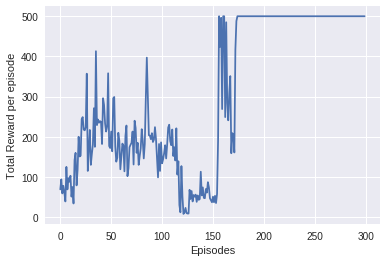

In [14]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'step_size_actor': .8,
    'step_size_critic': .5,
    'lambda_actor': .8,
    'lambda_critic': .8
}
model = ActorCritic(args)
rewards_train, _ = play_game(env, args, model, update=True, tot_episodes=200)
rewards_test, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
print "Average reward using Actor Critic with Traces: ", avg_reward
print "Plotting reward..."
plt.plot(rewards_train + rewards_test)
plt.xlabel("Episodes")
_ = plt.ylabel("Total Reward per episode")

### 4. Solving CartPole-v1 with Actor Critic
#### (Trace used only on actor $\lambda_{\text{actor}}=0.8,\ \ \lambda_{\text{critic}}=0.0$)

In [43]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'lambda_actor': .8,
    'lambda_critic': 0
}

print "No. of actions = ", args['n_actions']
print "State space = ", args['state_dim']

print "Starting hyperparameter search..."
configs = []
for step_size1 in np.arange(0.05, 1.05, .05):
  for step_size2 in np.arange(0.05, 1.05, .05):
      args['step_size_actor'] = step_size1
      args['step_size_critic'] = step_size2
      model = ActorCritic(args)
      play_game(env, args, model, update=True, tot_episodes=200)
      _, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
      configs.append((step_size1, step_size2, avg_reward))
#       print "Step sizes: {} Avg. Reward: {}".format((step_size1, step_size2), avg_reward)

No. of actions =  2
State space =  4
Starting hyperparameter search...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


### 4.i) Result of Hyperparameter search
#### Printing (step_size_actor, step_size_critic, avg_reward_per_episode)

In [44]:
sorted(configs, key=lambda tup: tup[-1], reverse=True)[:10]

[(0.8, 0.1, 497.85),
 (0.9500000000000001, 0.7000000000000001, 417.42),
 (0.7000000000000001, 0.8, 396.0),
 (0.35000000000000003, 0.9000000000000001, 382.43),
 (0.8500000000000001, 0.2, 376.44),
 (0.9000000000000001, 0.9500000000000001, 347.08),
 (0.6000000000000001, 0.35000000000000003, 325.04),
 (0.4, 0.25, 323.81),
 (0.7500000000000001, 0.1, 320.97),
 (0.6500000000000001, 0.3, 316.31)]

### 4.ii) Plotting results of best Actor Critic model (Trace only on Actor)
#### Hyperparameters:
* Gamma = 0.95
* $\alpha_{\text{actor}}$ = 0.8
* $\alpha_{\text{critic}}$ = 0.1
* $\lambda_{\text{actor}}$ = 0.8
* $\lambda_{\text{critic}}$ = 0.0

Average reward using Actor Critic with Traces:  497.85
Plotting reward...


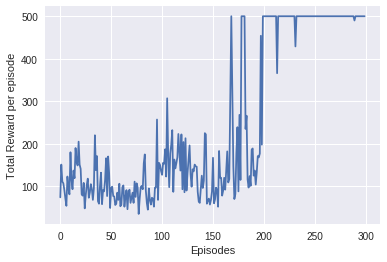

In [50]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'step_size_actor': .8,
    'step_size_critic': .1,
    'lambda_actor': .8,
    'lambda_critic': 0
}
model = ActorCritic(args)
rewards_train, _ = play_game(env, args, model, update=True, tot_episodes=200)
rewards_test, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
print "Average reward using Actor Critic with Traces: ", avg_reward
print "Plotting reward..."
plt.plot(rewards_train + rewards_test)
plt.xlabel("Episodes")
_ = plt.ylabel("Total Reward per episode")

### 5. Solving CartPole-v1 with Actor Critic
#### (Trace used only on actor $\lambda_{\text{actor}}=0.0,\ \ \lambda_{\text{critic}}=0.8$)

In [46]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'lambda_actor': 0.0,
    'lambda_critic': 0.8
}

print "No. of actions = ", args['n_actions']
print "State space = ", args['state_dim']

print "Starting hyperparameter search..."
configs = []
for step_size1 in np.arange(0.05, 1.05, .05):
  for step_size2 in np.arange(0.05, 1.05, .05):
      args['step_size_actor'] = step_size1
      args['step_size_critic'] = step_size2
      model = ActorCritic(args)
      play_game(env, args, model, update=True, tot_episodes=200)
      _, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
      configs.append((step_size1, step_size2, avg_reward))
#       print "Step sizes: {} Avg. Reward: {}".format((step_size1, step_size2), avg_reward)

No. of actions =  2
State space =  4
Starting hyperparameter search...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


### 5.i) Result of Hyperparameter search
#### Printing (step_size_actor, step_size_critic, avg_reward_per_episode)

In [47]:
sorted(configs, key=lambda tup: tup[-1], reverse=True)[:10]

[(0.05, 0.3, 500.0),
 (0.05, 0.15000000000000002, 495.82),
 (0.8, 0.15000000000000002, 331.76),
 (0.3, 0.25, 329.45),
 (0.8500000000000001, 0.3, 281.55),
 (0.8, 0.7500000000000001, 273.34),
 (0.45, 0.6500000000000001, 268.28),
 (0.9500000000000001, 0.6500000000000001, 258.45),
 (0.6000000000000001, 0.4, 253.57),
 (0.45, 0.55, 243.8)]

### 5.ii) Plotting results of best Actor Critic model (Trace only on Critic)
#### Hyperparameters:
* Gamma = 0.95
* $\alpha_{\text{actor}}$ = 0.05
* $\alpha_{\text{critic}}$ = 0.3
* $\lambda_{\text{actor}}$ = 0.0
* $\lambda_{\text{critic}}$ = 0.8

Average reward using Actor Critic with Traces:  500.0
Plotting reward...


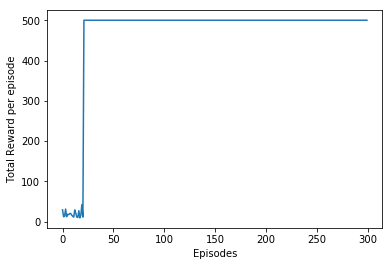

In [5]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'gamma': .95,
    'step_size_actor': .05,
    'step_size_critic': .3,
    'lambda_actor': 0.0,
    'lambda_critic': 0.8
}
model = ActorCritic(args)
rewards_train, _ = play_game(env, args, model, update=True, tot_episodes=200)
rewards_test, avg_reward = play_game(env, args, model, update=False, tot_episodes=100)
print "Average reward using Actor Critic with Traces: ", avg_reward
print "Plotting reward..."
plt.plot(rewards_train + rewards_test)
plt.xlabel("Episodes")
_ = plt.ylabel("Total Reward per episode")

### 5.ii) Storing GIF of the best Actor Critic model

In [7]:
_ = play_game(env, args, model, update=False, tot_episodes=5, store_gif=True)

### 5.ii) Displaying the GIF

In [8]:
from IPython.display import HTML
HTML('<img src="cartpole.gif">')

### 6.i) Effect of Gamma on Actor Critic
#### (For this experiment, traces are removed on both actor and critic, $\lambda_{\text{actor}}=\lambda_{\text{critic}}=0.0$)

In [7]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'lambda_actor': 0.0,
    'lambda_critic': 0.0
}
print "Starting hyperparameter search..."
configs = {}
for gamma in np.arange(0.90, 1.00, 0.01):
    configs[gamma] = []
    print "Performing a quick grid search for gamma = ", gamma
    for step_size1 in np.arange(0.05, 1.05, .05):
        for step_size2 in np.arange(0.05, 1.05, .05):
            args['step_size_actor'] = step_size1
            args['step_size_critic'] = step_size2
            args['gamma'] = gamma
            model = ActorCritic(args)
            play_game(env, args, model, update=True, tot_episodes=100)
            _, avg_reward = play_game(env, args, model, update=False, tot_episodes=10)
            configs[gamma].append((step_size1, step_size2, avg_reward))

Starting hyperparameter search...
Performing a quick grid search for gamma =  0.9


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


Performing a quick grid search for gamma =  0.91
Performing a quick grid search for gamma =  0.92
Performing a quick grid search for gamma =  0.93
Performing a quick grid search for gamma =  0.9400000000000001
Performing a quick grid search for gamma =  0.9500000000000001
Performing a quick grid search for gamma =  0.9600000000000001
Performing a quick grid search for gamma =  0.9700000000000001
Performing a quick grid search for gamma =  0.9800000000000001
Performing a quick grid search for gamma =  0.9900000000000001


### 6.ii) Printing best hyperparameters and average reward for each value of $\gamma$

Gamma =  0.9
Best hyperparameters: step_size_actor = 0.5 step_size_critic = 0.8
Gamma =  0.91
Best hyperparameters: step_size_actor = 0.15 step_size_critic = 0.55
Gamma =  0.92
Best hyperparameters: step_size_actor = 0.1 step_size_critic = 0.5
Gamma =  0.93
Best hyperparameters: step_size_actor = 0.45 step_size_critic = 0.7
Gamma =  0.9400000000000001
Best hyperparameters: step_size_actor = 0.75 step_size_critic = 0.45
Gamma =  0.9500000000000001
Best hyperparameters: step_size_actor = 0.75 step_size_critic = 0.3
Gamma =  0.9600000000000001
Best hyperparameters: step_size_actor = 0.55 step_size_critic = 1.0
Gamma =  0.9700000000000001
Best hyperparameters: step_size_actor = 0.2 step_size_critic = 0.3
Gamma =  0.9800000000000001
Best hyperparameters: step_size_actor = 0.15 step_size_critic = 0.3
Gamma =  0.9900000000000001
Best hyperparameters: step_size_actor = 0.75 step_size_critic = 0.45


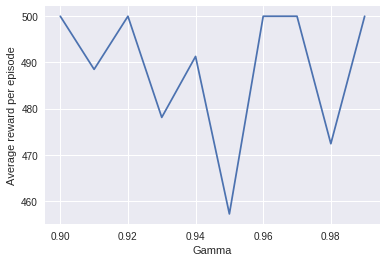

In [10]:
best_rewards = []
for key in np.arange(0.90, 1.00, 0.01):
    print "Gamma = ", key
    sorted_configs = sorted(configs[key], key=lambda tup: tup[-1], reverse=True)[:5]
    alpha_actor, alpha_critic, avg_reward = sorted_configs[0]
    print "Best hyperparameters: step_size_actor = {} step_size_critic = {}".format(
        alpha_actor, alpha_critic
    )
    best_rewards.append(sorted_configs[0][-1])

plt.plot(np.arange(0.90, 1.00, 0.01), best_rewards)
plt.xlabel("Gamma")
_ = plt.ylabel("Average reward per episode")

### 7.i) Effect of Lambda on Critic Trace ($\gamma = 0.95$ and $\lambda_{\text{actor}} = 0$ for these experiments)

In [24]:
args = {
    'n_actions': env.action_space.n,
    'state_dim': env.observation_space.shape[0],
    'lambda_actor': 0.0,
    'gamma': .95
}
print "Starting hyperparameter search..."
configs = {}
for lamda in np.arange(0.0, 1.0, 0.1):
    configs[lamda] = []
    print "Performing a quick grid search with lambda = ", lamda
    for step_size1 in np.arange(0.05, 1.05, .05):
        for step_size2 in np.arange(0.05, 1.05, .05):
            args['step_size_actor'] = step_size1
            args['step_size_critic'] = step_size2
            args['lambda_critic'] = lamda
            model = ActorCritic(args)
            play_game(env, args, model, update=True, tot_episodes=50)
            _, avg_reward = play_game(env, args, model, update=False, tot_episodes=10)
            configs[lamda].append((step_size1, step_size2, avg_reward))

Starting hyperparameter search...
Performing a quick grid search with lambda =  0.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


Performing a quick grid search with lambda =  0.1
Performing a quick grid search with lambda =  0.2
Performing a quick grid search with lambda =  0.30000000000000004
Performing a quick grid search with lambda =  0.4
Performing a quick grid search with lambda =  0.5
Performing a quick grid search with lambda =  0.6000000000000001
Performing a quick grid search with lambda =  0.7000000000000001
Performing a quick grid search with lambda =  0.8
Performing a quick grid search with lambda =  0.9


### 7.ii) Printing best hyperparameters and average reward for each value of $\lambda_{\text{critic}}$

lambda =  0.0
Best hyperparameters: step_size_actor = 0.9 step_size_critic = 0.6
lambda =  0.1
Best hyperparameters: step_size_actor = 0.25 step_size_critic = 0.6
lambda =  0.2
Best hyperparameters: step_size_actor = 0.25 step_size_critic = 0.9
lambda =  0.30000000000000004
Best hyperparameters: step_size_actor = 0.8 step_size_critic = 1.0
lambda =  0.4
Best hyperparameters: step_size_actor = 0.25 step_size_critic = 0.4
lambda =  0.5
Best hyperparameters: step_size_actor = 0.05 step_size_critic = 0.8
lambda =  0.6000000000000001
Best hyperparameters: step_size_actor = 0.35 step_size_critic = 0.55
lambda =  0.7000000000000001
Best hyperparameters: step_size_actor = 0.2 step_size_critic = 0.2
lambda =  0.8
Best hyperparameters: step_size_actor = 0.05 step_size_critic = 0.3
lambda =  0.9
Best hyperparameters: step_size_actor = 0.4 step_size_critic = 0.25


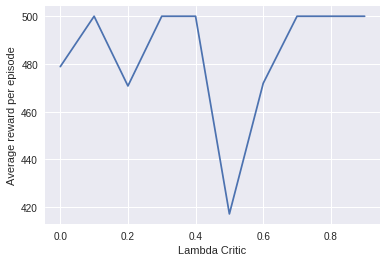

In [26]:
best_rewards = []
for key in np.arange(0.0, 1.0, 0.1):
    print "lambda = ", key
    sorted_configs = sorted(configs[key], key=lambda tup: tup[-1], reverse=True)[:5]
    alpha_actor, alpha_critic, avg_reward = sorted_configs[0]
    print "Best hyperparameters: step_size_actor = {} step_size_critic = {}".format(
        alpha_actor, alpha_critic
    )
    best_rewards.append(sorted_configs[0][-1])

plt.plot(np.arange(0.0, 1.0, 0.1), best_rewards)
plt.xlabel("Lambda Critic")
_ = plt.ylabel("Average reward per episode")